## Project 2: Numerical Methods for Differential Equations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigs

## Part 1: 2pBVP
Consider the problem:
\begin{equation}
    \tag{1}
    \begin{cases}
        y''=f(x,y)\\
        y(0)=\alpha\\
        y(L)=\beta
    \end{cases}
\end{equation}
On the intervall $x\in[0,L]$. This can be discretized with for $\Delta x=\frac{L}{N+1}$:
\begin{equation}
    \tag{2}
    \begin{cases}
        f(x_i,y_i)=\frac{y_{i+1}-2y_i+y_{i-1}}{\Delta x^2}\\
        y_0=\alpha\\
        y_{N+1}=\beta
    \end{cases}
\end{equation}
This resolves in a system of $N$ equations which can be summarized by $F(y)=\textbf{0}$ where $F$ is the operator such that:
\begin{equation}
    \tag{3}
    \begin{cases}
        F_1(y)=\frac{y_2-2y_1+\alpha}{\Delta x^2}-f(x_1,y_1)\\
        F_i=\frac{y_{i+1}-2y_i+y_{i-1}}{\Delta x^2}-f(x_i,y_i), \qquad i\in[2,N-1]\\
        F_{N}=\frac{\beta-2y_N+y_{N-1}}{\Delta x^2}-f(x_N,y_N)
    \end{cases}
\end{equation}

In a very fundamental case, $F$ is linear and $f(x,y)$ depends only on $x$. This reduces the problem to solving:
$$
\frac{1}{\Delta x^2}
\left(\begin{array}{c c c c} 
-2 & 1 & 0 & \dots\\
1  & -2 & 1 & \dots\\
0 & 1 & -2 & \dots\\
\dots & \dots & \dots & \dots\\
\dots & 1 & -2 & 1\\
\dots & 0 & 1 & -2  
\end{array}\right)
\left(\begin{array}{c} 
    y_1 \\ y_2 \\ .\\.\\.\\ y_N
\end{array}\right)
=
\left(\begin{array}{c} 
    -\frac{\alpha}{\Delta x^2} +f(x_1)\\ f(x_2) \\ .\\.\\ f(x_{N-1})\\ -\frac{\beta}{\Delta x^2}+f(x_N)
\end{array}\right)
$$ 

## Task 1.1
Write a 2pBVP solver

In [2]:
def toeplitz_like(dim):
    return csr_matrix(diags([1, -2, 1], [-1, 0, 1], shape=(dim, dim)))

def twopBVP(fvec, alpha, beta, L, N):

    dx = L/(N+1)
    toeplitz = toeplitz_like(len(fvec))/(dx*dx)

    fvec[0]  = fvec[0] -  alpha/(dx*dx)
    fvec[-1] = fvec[-1] - beta /(dx*dx)

    return spsolve(toeplitz, fvec)

def twopBVP_withSteplength(fvec, alpha, beta, L, N):

    dx = L/(N+1)
    toeplitz = toeplitz_like(len(fvec))/(dx*dx)

    fvec[0]  = fvec[0]  -  alpha/(dx*dx)
    fvec[-1] = fvec[-1] - beta/(dx*dx)

    return spsolve(toeplitz, fvec), dx

#### Testing

To test the 2pBVP solver above, it is first applied to the function $y=e^{-x}$ which gives that $f(x)=y(x)$ and the intervall is set to $x\in[0,10]$ For which $\alpha=1, \beta = e^{-10}$ and the length $L$ of the intervall is $10$. The global error of the function is further plotted against steplength $\Delta x = \frac{L}{N+1}$

In [3]:
def f(x):
    return np.exp(-x)

x = np.linspace(0,10,1000)

fvec = np.zeros(1000-2)
for i in range(len(fvec)):
    fvec[i] = f(x[i])

y = twopBVP(fvec, 1, np.e**(-10), 1, 100)
y = np.concatenate(([1],y))
y = np.concatenate((y,[np.e**(-10)]))

exact_sol = np.zeros_like(x)

for i, x_n in enumerate(x):
    exact_sol[i] = np.e**(-x_n)
 

Text(0, 0.5, 'y')

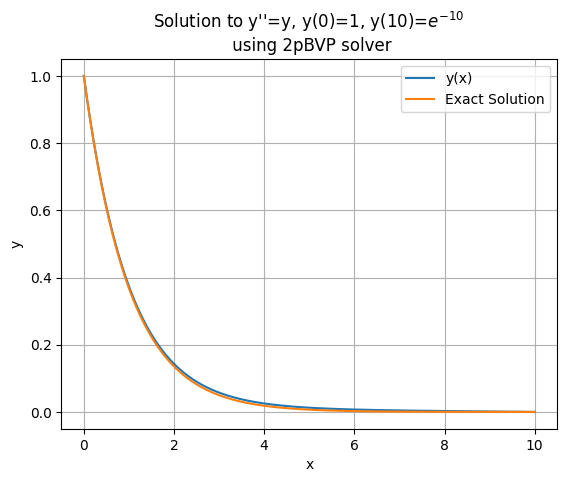

In [4]:
plt.plot(x,y, label='y(x)')
plt.plot(x,exact_sol, label='Exact Solution')
plt.title('Solution to y\'\'=y, y(0)=1, y(10)=$e^{-10}$ \n using 2pBVP solver')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

In [37]:
Nvec     = [int(np.power(2,i)) for i in range(3, 10)]
stepgrid = np.zeros_like(Nvec)
error    = np.zeros_like(Nvec)
stepgrid = stepgrid.astype(float)
error    = error.astype(float)

for i, N in enumerate(Nvec):
    stepgrid[i] = 10/(N+1)
    approx = twopBVP(fvec, 1, np.e**(-10), 10, N)
    temp_error = np.zeros_like(approx)

    for j, x_approx in enumerate(approx):
        temp_error[j] = x_approx - np.e**(-(j*stepgrid[i]))
    error[i] = np.linalg.norm(temp_error)

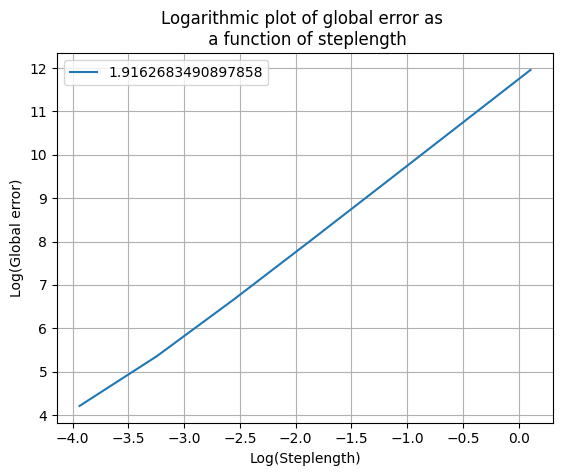

In [38]:
k = np.log(error[-1]/error[0])/np.log(stepgrid[-1]/stepgrid[0])

plt.plot(np.log(stepgrid), np.log(error), label=k)
plt.title('Logarithmic plot of global error as \n a function of steplength')
plt.xlabel('Log(Steplength)')
plt.ylabel('Log(Global error)')
plt.legend()
plt.grid()

## The Beam Equation

An elastic beam under load is deflected in accordance with its material properties and the applied load. According to elasticity theory, the deflection $u$ is governed by the differential equations:
\begin{equation}
\tag{4}
    \begin{cases}
        M''=q\\
        u''=\frac{M}{EI}
    \end{cases}
\end{equation}
where $q(x)$ is the load density (N/m); $M(x)$ is the bending moment (Nm);
$E$ is Young’s modulus of elasticity (N/m $^2$); $I$ is the beam’s cross-section
moment of inertia (m $^4$); and u is the beam’s centerline deflection (m). The beam is supported which gives that $u(0)=u(L)=0$. Furthermore, it is assumed that no bending is given at endpoints resulting in $M(0)=M(L)=0$

## Task 1.2

Given that $L=10$, $E=1.9 \cdot 10^{11}$ Nm $^{-2}$ and the beam cross-section moment of inertia is given as 
\begin{equation*}
    I(x)=\frac{1}{1000}\left(3-2\cos^{12}\frac{\pi x}{L}\right)
\end{equation*}
The problem is solved for the load $q(x)=-50\ 000$ N/m below.

Firstly, the equation for $M$ is solved using the 2pBVP Solver from above. $N=999$ steps corresponding to $\Delta x=0.01$ is done.

In [7]:
q = -50000
L = 10
beam_vec = np.linspace(0,L,1001)

q_vec = q * np.ones(1001-2)

M = twopBVP(q_vec, 0, 0, L, 999)
M = np.concatenate(([0],M))
M = np.concatenate((M,[0]))

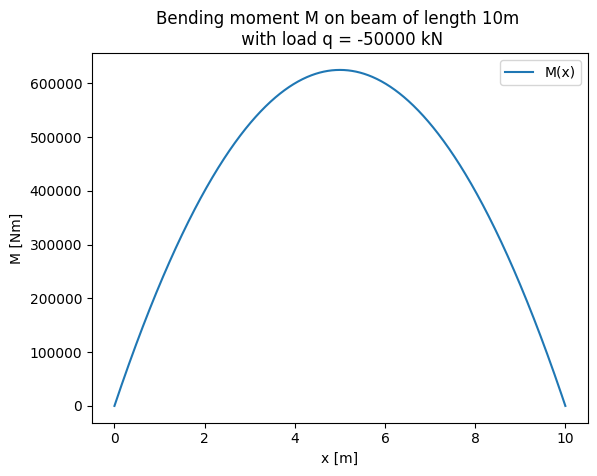

In [8]:
plt.plot(beam_vec, M, label='M(x)')
plt.title('Bending moment M on beam of length 10m \n with load q = -50000 kN')
plt.xlabel('x [m]')
plt.ylabel('M [Nm]')
plt.legend()

Further, the equation for $u$ is solved.

In [9]:
E     = 1.9e11
E_inv = 1/E

def I(x):
    return 0.001*(3-2*(np.cos(np.pi*x/L))**(12))

def I_inv(x):
    return 1/I(x)

beam = np.linspace(0,10,1001)

f_vec_beam = np.zeros(1001-2)

for i in range(len(f_vec_beam)):
    f_vec_beam[i] = E_inv * I_inv(beam[i+1]) * M[i+1]


u = twopBVP(f_vec_beam, 0, 0, L, 999)
u = np.concatenate(([0],u))
u = np.concatenate((u,[0]))

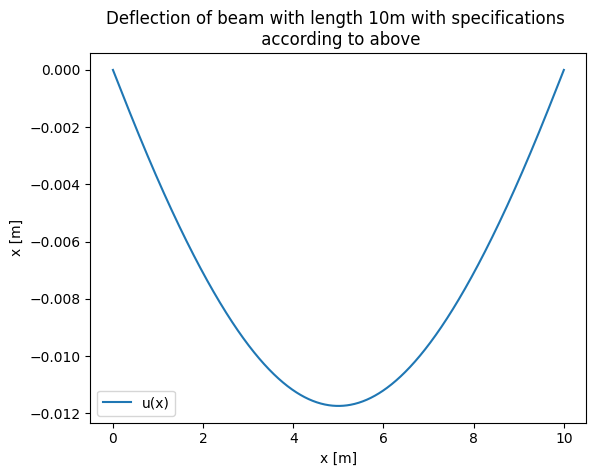

In [10]:
plt.plot(beam_vec, u, label='u(x)')
plt.title('Deflection of beam with length 10m with specifications \n according to above')
plt.xlabel('x [m]')
plt.ylabel('x [m]')
plt.legend()

To determine the accuracy of the code, the deflection at the beam's midpoint 

In [11]:
print(u[500])

-0.011741059085875718


To eight exact digits, this value is:
\begin{equation*}
-0.01174106 \text{ m}
\end{equation*}

## Part 2

Sturm-Liouville problems are formulated as:
\begin{equation}
    \tag{5}
    \begin{cases}
    \frac{d}{dx}\left(p(x)\frac{dy}{dx}\right)-q(x)y=\lambda y\\
    y(\alpha) = 0\\
    y(\beta) = 0
    \end{cases}
\end{equation}


## Task 2.1

The Sturm-Liouville problem:
\begin{equation}
\tag{6}
    \begin{cases}
        u''=\lambda u\\
        u(0)=0\\
        u'(1)=0
    \end{cases}
\end{equation}
Has analytical solutions for $\lambda<0$ as $u(x)=a\sin\sqrt{-\lambda}x, \quad a\in\mathbb{R}$ where the second boundary condition implies $\sqrt{-\lambda}=(2k+1)\frac{\pi}{2},\quad k=0,1,2,...$. 


To take into account the Neumann boundary condition, the third approach from the lectures is used. The following is used:
\begin{equation*}
    y'(x)=\frac{y(x-2\Delta x)-4y(x-\Delta x+3y(x))}{2\Delta x}+O(\Delta x^2)
\end{equation*}
This gives the discretization:
\begin{equation*}
    \begin{cases}
        x_k=k\Delta x\\
        \Delta x = \frac{1}{N+1}\\
        \beta = y'(1)\approx\frac{y_{N+1}-y_{N-1}}{2\Delta x}
    \end{cases}
\end{equation*}
With the condition $\beta = 0$ this gives $y_{N+1}=y_{N-1}+2\Delta x\beta$. This is used to rewrite the 2pBVP problem from above. The Toeplitz matrix now instead becomes:
$$
\frac{1}{\Delta x^2}
\left(\begin{array}{c c c c} 
-2 & 1 & 0 & \dots\\
1  & -2 & 1 & \dots\\
0 & 1 & -2 & \dots\\
\dots & \dots & \dots & \dots\\
\dots & 1 & -2 & 1\\
\dots & 0 & 1+1 & -2 
\end{array}\right)
$$

In [12]:
# Returns the NxN matrix of size dim described above as a csr_matrix
def Neumann_toeplitz_dim(dim):
    dx = 1/(dim)

    toeplitz              = diags([1, -2, 1], [-1, 0, 1], shape=(dim, dim)).toarray()
    toeplitz[-1, dim - 2] = 2
    toeplitz              = toeplitz/(dx*dx)

    return csr_matrix(toeplitz)

three_first_eigenvalues = -0.25*np.pi**2*np.array([1, 9, 25])

For the specific problem (6), the error of the three first eigenvalues $-\frac{\pi^2}{4}, -3^2\frac{\pi^2}{4}, -5^2\frac{\pi^2}{4}$ is studied as a function of number of interior points $N$.

In [13]:
Nvec         = [int(np.power(2,i)) for i in range(3, 10)]
eigen_errors = np.zeros((len(Nvec), 3))
stepgrid     = np.zeros_like(Nvec)
stepgrid     = stepgrid.astype(float)


for i, n in enumerate(Nvec):
    stepgrid[i] = 1/(n)
    val, vec = eigs(Neumann_toeplitz_dim(n), 3, None, None, 'SM')
    val -= three_first_eigenvalues
    val = abs(val)
    eigen_errors[i,:] = val

# The error of the first eigenvalue as a function of Nvec, 
# is now in eigen_errors[:,0], the second in [:,1] and the 
# third in [:,2].

Below, the respective errors are plotted against number of interior points N

Slope for first plot:  -1.9996906951063258
Slope of the second plot:  1.9996906951063258


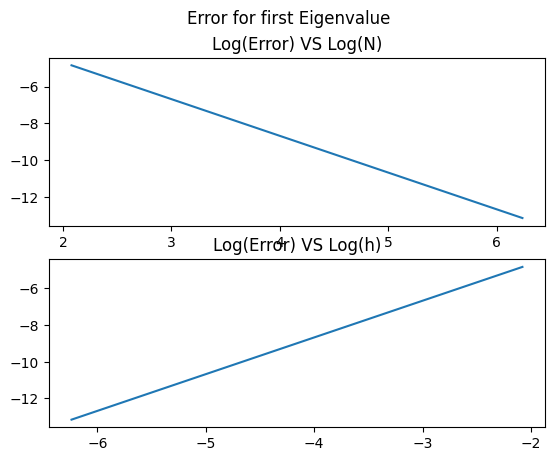

In [14]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Error for first Eigenvalue')
ax1.plot(np.log(Nvec), np.log(eigen_errors[:,0]))
ax2.plot(np.log(stepgrid), np.log(eigen_errors[:,0]))
ax1.title.set_text('Log(Error) VS Log(N)')
ax2.title.set_text('Log(Error) VS Log(h)')

print('Slope for first plot: ', np.log(eigen_errors[-1,0]/eigen_errors[0,0])/np.log(Nvec[-1]/Nvec[0]))
print('Slope of the second plot: ', np.log(eigen_errors[-1,0]/eigen_errors[0,0])/np.log(stepgrid[-1]/stepgrid[0]))

Slope for first plot:  -1.9972209071706084
Slope of the second plot:  1.9972209071706084


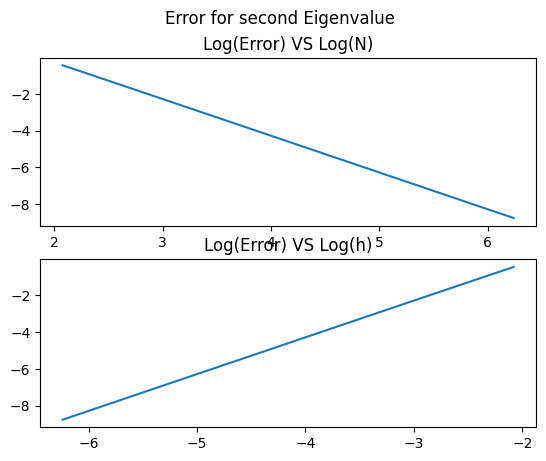

In [15]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Error for second Eigenvalue')
ax1.plot(np.log(Nvec), np.log(eigen_errors[:,1]))
ax2.plot(np.log(stepgrid), np.log(eigen_errors[:,1]))
ax1.title.set_text('Log(Error) VS Log(N)')
ax2.title.set_text('Log(Error) VS Log(h)')

print('Slope for first plot: ', np.log(eigen_errors[-1,1]/eigen_errors[0,1])/np.log(Nvec[-1]/Nvec[0]))
print('Slope of the second plot: ', np.log(eigen_errors[-1,1]/eigen_errors[0,1])/np.log(stepgrid[-1]/stepgrid[0]))


Slope for first plot:  -1.9922858811901352
Slope of the second plot:  1.9922858811901352


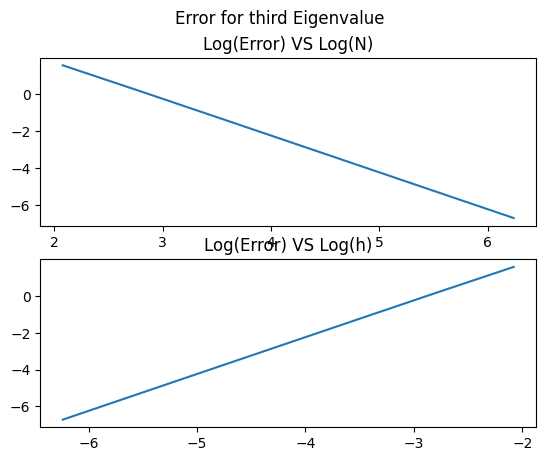

In [16]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Error for third Eigenvalue')
ax1.plot(np.log(Nvec), np.log(eigen_errors[:,2]))
ax2.plot(np.log(stepgrid), np.log(eigen_errors[:,2]))
ax1.title.set_text('Log(Error) VS Log(N)')
ax2.title.set_text('Log(Error) VS Log(h)')

print('Slope for first plot: ', np.log(eigen_errors[-1,2]/eigen_errors[0,2])/np.log(Nvec[-1]/Nvec[0]))
print('Slope of the second plot: ', np.log(eigen_errors[-1,2]/eigen_errors[0,2])/np.log(stepgrid[-1]/stepgrid[0]))


In [17]:
val, vec = eigs(Neumann_toeplitz_dim(499), 3, None, None, 'SM')
print(val)

vec1 = vec[:,0]
vec2 = vec[:,1]
vec3 = vec[:,2]

bound1 = (1/3)*(4*vec1[-1]-vec1[len(vec1)-2])
bound2 = (1/3)*(4*vec2[-1]-vec2[len(vec2)-2])
bound3 = (1/3)*(4*vec3[-1]-vec3[len(vec2)-2])

vec1 = np.concatenate(([0], vec1))
vec1 = np.concatenate((vec1, [bound1]))
vec2 = np.concatenate(([0], vec2))
vec2= np.concatenate((vec2, [bound2]))
vec3 = np.concatenate(([0], vec3))
vec3 = np.concatenate((vec3, [bound3]))


[ -2.46739906+0.j -22.20644487+0.j -61.68375408+0.j]


For $N=499$, the three smallest eigenvalues to an accuracy of 8 digits are given by:
\begin{equation}
\tag{7}
    \begin{cases}
        \lambda_1=-2.45753937\\
        \lambda_2=-22.11771053\\
        \lambda_3=-61.43728602
    \end{cases}
\end{equation}
The analytical values are:
\begin{equation*}
    \begin{cases}
        \lambda_1=-\frac{\pi^2}{4}\approx-2.467401\\
        \lambda_2=-\frac{9\pi^2}{4}\approx-22.2066099\\
        \lambda_3=-\frac{25\pi^2}{4}\approx-61.68502751
    \end{cases}
\end{equation*}

c:\Users\filip\Desktop\NumDiff\.venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\filip\Desktop\NumDiff\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


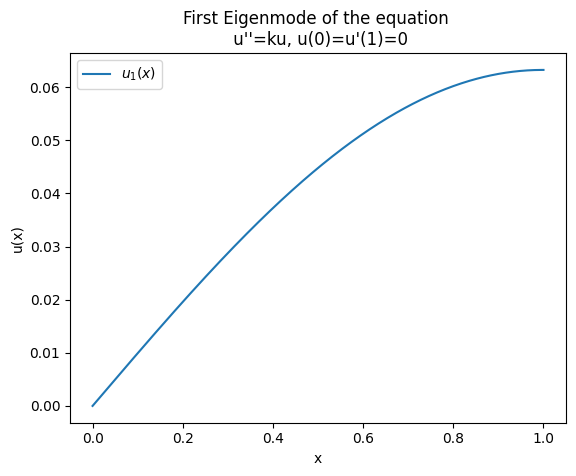

In [18]:
x = np.linspace(0,1,501)

plt.plot(x, vec1, label=r'$u_1(x)$')
plt.title('First Eigenmode of the equation \n u\'\'=ku, u(0)=u\'(1)=0')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

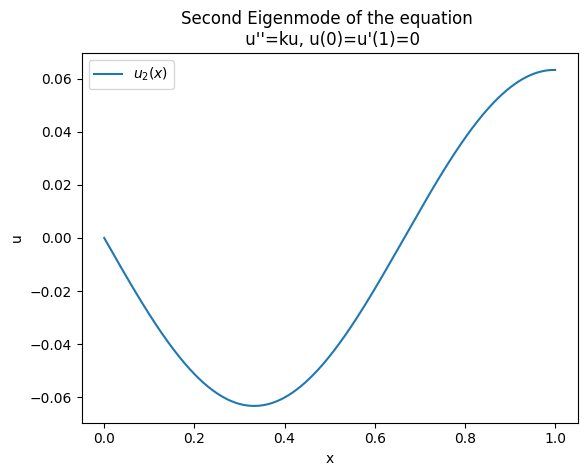

In [19]:
plt.plot(x, vec2, label=r'$u_2(x)$')
plt.title('Second Eigenmode of the equation \n u\'\'=ku, u(0)=u\'(1)=0')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

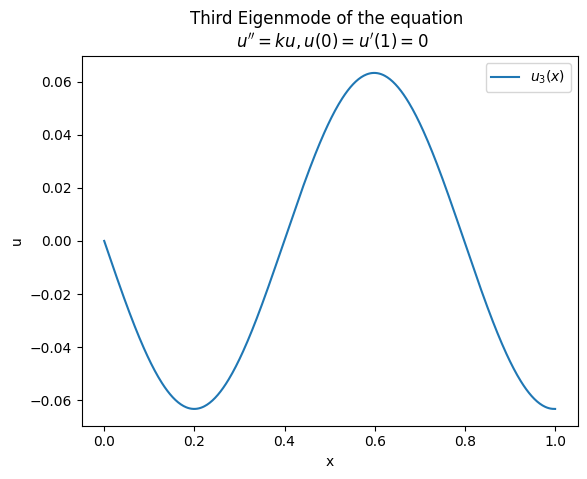

In [20]:
plt.plot(x, vec3, label=r'$u_3(x)$')
plt.title('Third Eigenmode of the equation \n $u\'\'=ku, u(0)=u\'(1)=0$')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

## The Schrödinger equation
The time-independent Schrödinger equation is:
\begin{equation}
    \tag{8}
    -\frac{\hbar^2}{2m}\nabla\psi+V\psi=E\psi
\end{equation}
With units normalized and in one dimension, this is reduced to (9)
\begin{equation}
    \tag{9}
    \psi''(x)-V(x)\psi(x)=-E\psi(x)
\end{equation}
And can thus be interpreted as a eigenvalue problem. Assuming that the potential is infinite outside of the defined well, the boundary conditions $\psi(0)=\psi(1)=0$

## Task 2.2
Construct a solver for the stationary Schrödinger equation for any
given potential $V(x)$. The solver should compute the first few eigenval-
ues (say up to six to ten eigenvalues), and plot both the wave functions $\psi$
and the probability densities $|\psi|^2$.

To do this, the equation (9) is rewritten as:

\begin{equation*}
    \begin{cases}
        \psi''(x)=(V(x)-E)\psi(x)\\
        \psi(0)=0\\
        \psi(1)=0
    \end{cases}
\end{equation*}

In [21]:
def toeplitz_SE(dim):
    return diags([1, -2, 1], [-1, 0, 1], shape=(dim, dim)).toarray()

def potential_to_matrix(dim, V, x0, xf):
    V_vec = np.zeros(dim)
    V_vec = V_vec.astype(float)
    dx    = (xf-x0)/(dim+1)

    for k in range(dim):
        V_vec[k] = V((k+1)*dx)

    return np.diag(V_vec)

def SE_matrix(V, x0, xf, N):
    dx = (xf-x0)/(N+1)
    return csr_matrix(toeplitz_SE(N)/(dx*dx) - potential_to_matrix(N, V, x0, xf))

def SE_solver(V, x0, xf, N, nbrEigen):
    val, vec = eigs(SE_matrix(V, x0, xf, N), nbrEigen, None, None, 'SM')
    grid = np.linspace(x0, xf, N+2)

    return grid, vec, val


#### Test for $V(x)=0$

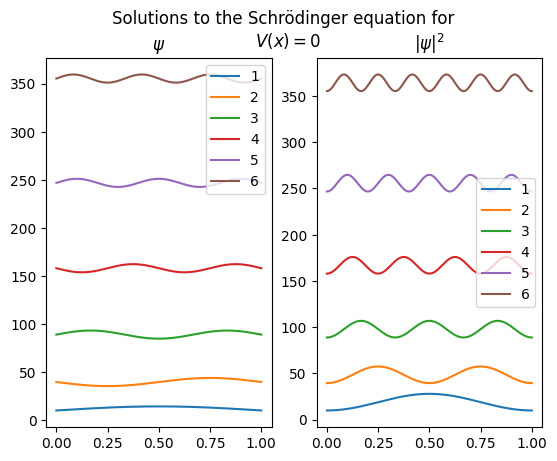

In [22]:
def V0(x):
    return 0

grid, vec, val = SE_solver(V0, 0, 1, 1000, 6)

fig, (psi, prob) = plt.subplots(1, 2)
fig.suptitle('Solutions to the Schrödinger equation for \n '+r'$V(x)=0$')

for k in range(6):
    vec0 = vec[:,k]
    vec0 = np.concatenate(([0], vec0))
    vec0 = np.concatenate((vec0, [0]))

    Norm = 3/np.sqrt((1/1001)*sum(abs(vec0)**2))
    vec0 = Norm*vec0

    prob0 = abs(vec0)**2

    vec0 = vec0 - val[k]
    prob0 = prob0 - val[k]
    psi.plot(grid, vec0, label=k+1)
    prob.plot(grid, prob0, label=k+1)
psi.legend()
psi.title.set_text(r'$\psi$')
prob.legend()
prob.title.set_text(r'$|\psi|^2$')
    

## Handling of potentials $\neq 0$

#### Firstly $V(x) = 700(0.5 − |x − 0.5|)$

In [23]:
def V1(x):
    return 700*(0.5-np.sqrt((x-0.5)**2))

grid, vec1, val1 = SE_solver(V1, 0, 1, 1000, 6)

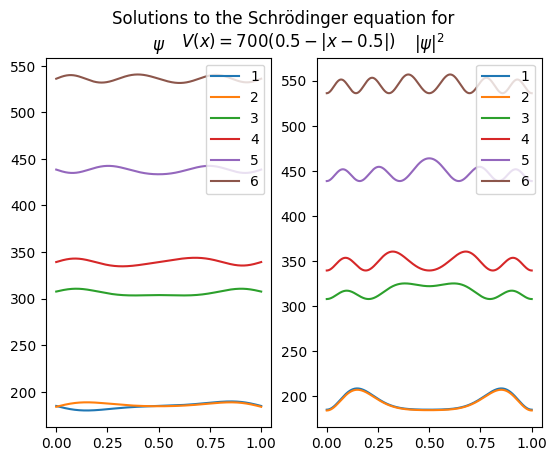

In [24]:
fig1, (psi1, prob1) = plt.subplots(1, 2)
fig1.suptitle('Solutions to the Schrödinger equation for \n '+r'$V(x)=700(0.5-|x-0.5|)$')
for k in range(6):
    vec0 = vec1[:,k]
    vec0 = np.concatenate(([0], vec0))
    vec0 = np.concatenate((vec0, [0]))

    Norm = 3/np.sqrt((1/1001)*sum(abs(vec0)**2))
    vec0 = Norm*vec0

    prob0 = abs(vec0)**2

    vec0 = vec0 - val1[k]
    prob0 = prob0 - val1[k]
    psi1.plot(grid, vec0, label=k+1)
    prob1.plot(grid, prob0, label=k+1)
psi1.legend()
psi1.title.set_text(r'$\psi$')
prob1.legend()
prob1.title.set_text(r'$|\psi|^2$')

#### Secondly $V(x)=800\sin^2 πx$

In [25]:
def V2(x):
    return 800*(np.sin(np.pi*x))**2

grid, vec1, val1 = SE_solver(V2, 0, 1, 1000, 6)

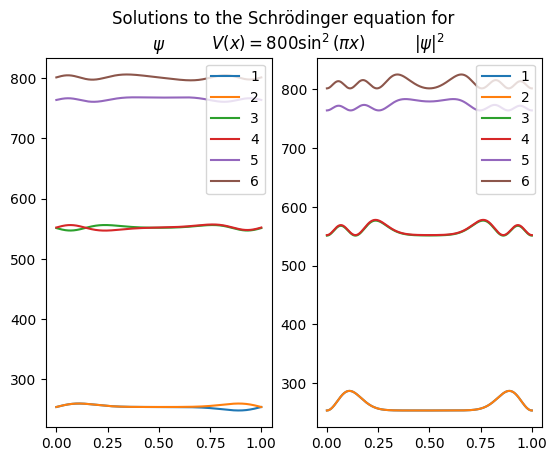

In [26]:
fig1, (psi1, prob1) = plt.subplots(1, 2)
fig1.suptitle('Solutions to the Schrödinger equation for \n '+r'$V(x)=800\sin^2(\pi x)$')
for k in range(6):
    vec0 = vec1[:,k]
    vec0 = np.concatenate(([0], vec0))
    vec0 = np.concatenate((vec0, [0]))

    N = 3/np.sqrt((1/1001)*sum(abs(vec0)**2))
    vec0 = N*vec0

    prob0 = abs(vec0)**2

    vec0 = vec0 - val1[k]
    prob0 = prob0 - val1[k]
    psi1.plot(grid, vec0, label=k+1)
    prob1.plot(grid, prob0, label=k+1)
psi1.legend()
psi1.title.set_text(r'$\psi$')
prob1.legend()
prob1.title.set_text(r'$|\psi|^2$')

## Quadruplet states

In [27]:
def V3(x):
    return 800*(np.sin(2*np.pi*x))**2

grid, vec1, val1 = SE_solver(V3, 0, 1, 1000, 6)

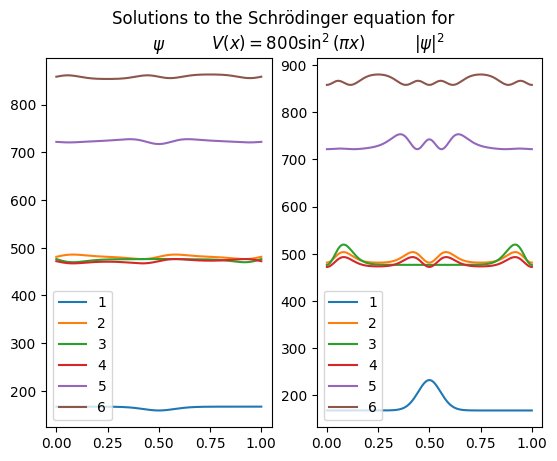

In [28]:
fig1, (psi1, prob1) = plt.subplots(1, 2)
fig1.suptitle('Solutions to the Schrödinger equation for \n '+r'$V(x)=800\sin^2(\pi x)$')
for k in range(6):
    vec0 = vec1[:,k]
    vec0 = np.concatenate(([0], vec0))
    vec0 = np.concatenate((vec0, [0]))

    N = 3/np.sqrt((1/1001)*sum(abs(vec0)**2))
    vec0 = N*vec0

    prob0 = abs(vec0)**2

    vec0 = vec0 - val1[k]
    prob0 = prob0 - val1[k]
    psi1.plot(grid, vec0, label=k+1)
    prob1.plot(grid, prob0, label=k+1)
psi1.legend()
psi1.title.set_text(r'$\psi$')
prob1.legend()
prob1.title.set_text(r'$|\psi|^2$')

#### Finally, the potential $V(x)=\delta(x-\frac{1}{2})$, where $\delta$ is the dirac function is examined

In [29]:
def V_delta(x):
    if(x == 500/1001):
        return 2**20
    if(x == 501/1001):
        return 2**20
    return 0

grid, vec1, val1 = SE_solver(V_delta, 0, 1, 1000, 6)

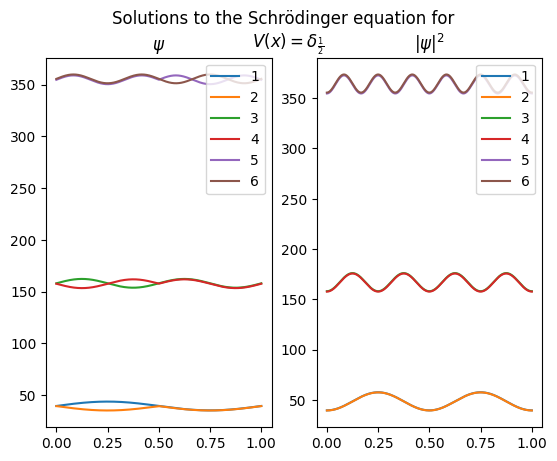

In [30]:
fig1, (psi1, prob1) = plt.subplots(1, 2)
fig1.suptitle('Solutions to the Schrödinger equation for \n '+r'$V(x)=\delta_{\frac{1}{2}}$')
for k in range(6):
    vec0 = vec1[:,k]
    vec0 = np.concatenate(([0], vec0))
    vec0 = np.concatenate((vec0, [0]))

    N = 3/np.sqrt((1/1001)*sum(abs(vec0)**2))
    vec0 = N*vec0

    prob0 = abs(vec0)**2

    vec0 = vec0 - val1[k]
    prob0 = prob0 - val1[k]
    psi1.plot(grid, vec0, label=k+1)
    prob1.plot(grid, prob0, label=k+1)
psi1.legend()
psi1.title.set_text(r'$\psi$')
prob1.legend()
prob1.title.set_text(r'$|\psi|^2$')